In [2]:
#%% Imports
import numpy as np
import pandas as pd
from scipy.optimize import linear_sum_assignment
import cv2 as cv

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# %% Settings 
sns.set()

In [5]:
# %% Loading dataframe from new and old result
#df_new = pd.read_hdf('df_batch_0.hdf', key='df')
df_new = pd.read_hdf('../../notebooks/df_new.hdf', key='df')
df_old = pd.read_hdf('../../data/testing_data/4arenas/old_combined.hdf', 'data')

In [6]:
# %% We need to match the right frame numbers
initial_frame = np.max([df_old['frame'].min(), df_new['frame'].min()])
final_frame = np.min([df_old['frame'].max(), df_new['frame'].max()])

df_old = df_old.query(f'{initial_frame} <= frame <= {final_frame}')[['frame', 'ID', 'x', 'y']]
df_new = df_new.query(f'{initial_frame} <= frame <= {final_frame}')

In [7]:
# %% Sorting
df_new = df_new.sort_values(by=['frame', 'ID'])
df_old = df_old.sort_values(by=['frame', 'ID'])

In [8]:
# %% Let's check if that worked
print(df_old['frame'].min(), df_old['frame'].max())
print(df_new['frame'].min(), df_new['frame'].max())

99 108053
99.0 108053.0


In [9]:
# %% We don't have the same number of flies due to Michaelf fuckup
n_flies_old = df_old.ID.unique().size
n_flies_new = df_new.ID.unique().size 

print(n_flies_new, n_flies_old)

27 26


15.787669652666079 15.495967217311735


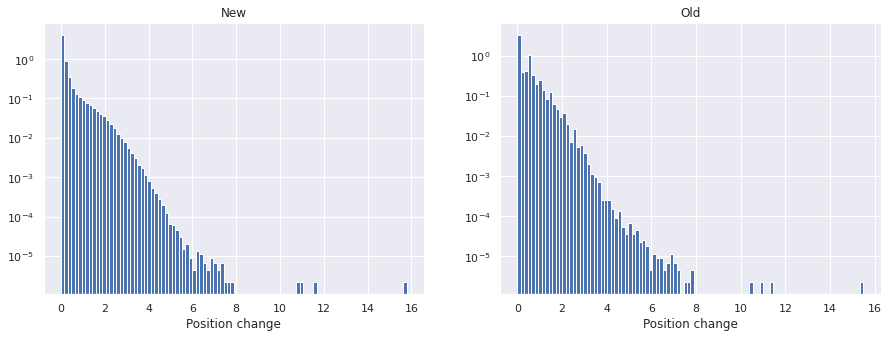

In [10]:
#%% Let's first study the trajectories themselves. They should be continuous, so the jump frame-to-frame should be small
change_new = np.sum(np.diff(df_new[['x', 'y']].to_numpy().reshape(-1, n_flies_new, 2), axis=0)**2, axis=2)**(1/2)
change_old = np.sum(np.diff(df_old[['x', 'y']].to_numpy().reshape(-1, n_flies_old, 2), axis=0)**2, axis=2)**(1/2)

print(np.max(change_new), np.max(change_old))

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.hist(change_new.flatten(), bins=100, log=True, density=True)
plt.title('New')
plt.xlabel('Position change')

plt.subplot(122)
plt.hist(change_old.flatten(), bins=100, log=True, density=True)
plt.title('Old')
plt.xlabel('Position change')

plt.show()

In [11]:
# %% Internally the trajectories seem good; no weird jumps. 
# %% Now we calculate the distance between them to get a match 
# %% We already sorted them the same way so we can simply reshape. We do need to subtract the initial position  though 
df_new_offset = df_new[['x', 'y']].to_numpy().reshape(-1, n_flies_new, 2)
df_new_offset -= df_new_offset[0, :, :]

df_old_offset = df_old[['x', 'y']].to_numpy().reshape(-1, n_flies_old, 2)
df_old_offset -= df_old_offset[0, :, :]

distances = np.sum((np.expand_dims(df_old_offset, 1) - np.expand_dims(df_new_offset, 2))**2, axis=-1)**(1/2)

Text(0.5, 1.0, 'Max distance')

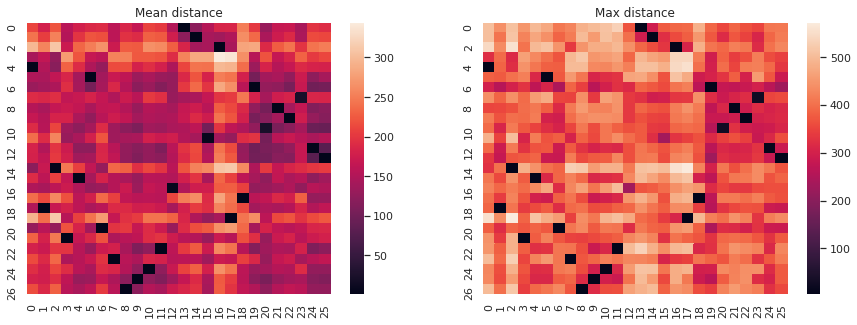

In [12]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
sns.heatmap(np.mean(distances, axis=0))
plt.title('Mean distance')
plt.subplot(122)
sns.heatmap(np.max(distances, axis=0))
plt.title('Max distance')

In [13]:
max_mean_dist = np.stack([np.min(np.max(distances, axis=0), axis=1), np.min(np.mean(distances, axis=0), axis=1)], axis=1)
print(max_mean_dist)

[[ 10.86100357   0.59478947]
 [  7.03348895   0.71099608]
 [  5.31582156   0.89490416]
 [295.52950657 125.60767597]
 [  5.46110039   0.65424481]
 [  5.45600988   0.87159816]
 [  5.54177944   0.7828473 ]
 [ 26.61744874  22.52129911]
 [  7.54058259   0.65853685]
 [  6.82150579   0.80832962]
 [ 27.78398916  22.24396826]
 [233.02612005   6.18280542]
 [ 10.75808245   0.75073209]
 [  5.7599403    0.76810108]
 [  4.67284025   1.4213356 ]
 [ 10.11324833   0.85494275]
 [232.25373699   6.34796112]
 [  6.48974479   0.57662306]
 [  5.28438892   0.73227494]
 [  5.37412953   0.55064338]
 [  4.87442249   0.59663761]
 [  4.28798863   0.63031077]
 [  5.55937024   0.84029542]
 [  8.08932409   0.67105064]
 [  7.12246253   0.71373303]
 [  5.0801395    0.56544863]
 [  5.56181307   1.04675386]]


So there are some discrepancies, mostly among 7, 13 and 17. We have one unmatched, which, given the mean distance is probably 7. That means 13 and 17 probably have an inversion somewhere? Let's first match the indices so we can compare.

In [14]:
new_idx, old_idx = linear_sum_assignment(np.mean(distances, axis=0))

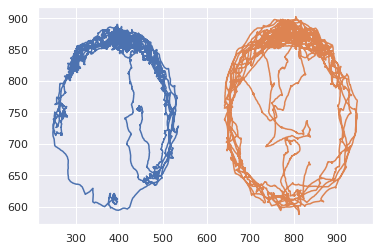

In [15]:
#%% Let's see if they're in the same quadrant
ID = 13
plt.plot(df_new.query(f'ID == {ID}')[['x']], df_new.query(f'ID == {ID}')[['y']])
ID = 17
plt.plot(df_new.query(f'ID == {ID}')[['x']], df_new.query(f'ID == {ID}')[['y']])

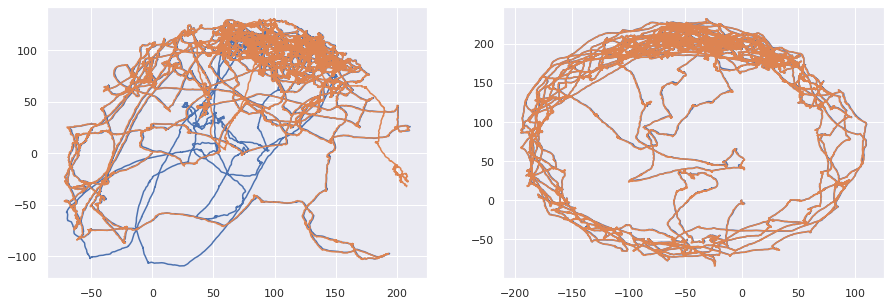

In [19]:
# %% Now let's plot them with Nicolas' result
plt.figure(figsize=(15, 5))
plt.subplot(121)
new_ID = 11
old_ID = old_idx[new_idx==new_ID]
plt.plot(df_new_offset[:, new_ID, 0], df_new_offset[:, new_ID, 1])
plt.plot(df_old_offset[:, old_ID, 0], df_old_offset[:, old_ID, 1])

plt.subplot(122)
new_ID = 17
old_ID = old_idx[new_idx==new_ID]
plt.plot(df_new_offset[:, new_ID, 0], df_new_offset[:, new_ID, 1])
plt.plot(df_old_offset[:, old_ID, 0], df_old_offset[:, old_ID, 1])

Text(0.5, 1.0, 'Distance in position between old and new approach')

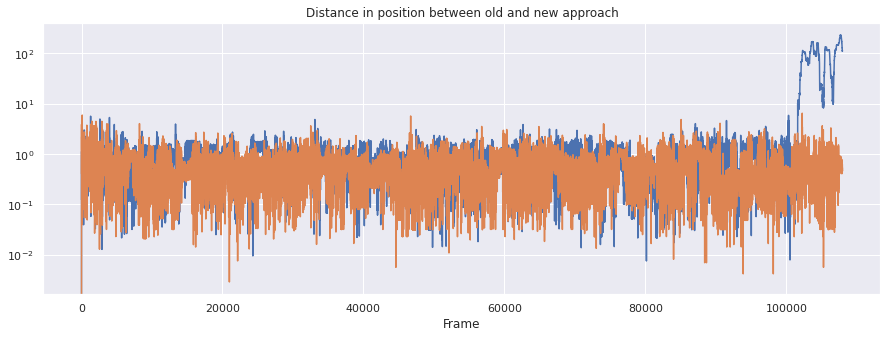

In [24]:
# %% And the distance in time between them
plt.figure(figsize=(15, 5))
new_ID = 11
old_ID = old_idx[new_idx==new_ID]
plt.semilogy(distances[:, new_ID, old_ID])
new_ID = 17
old_ID = old_idx[new_idx==new_ID]

plt.semilogy(distances[:, new_ID, old_ID])
plt.xlabel('Frame')
plt.title('Distance in position between old and new approach')

So them jumping at the same time is definitely an inversion. Now to figure it where it happens and see who's right.

In [21]:
old_idx[new_idx==13].item()

25

In [22]:
# %% The inversion happens after 100000, let's isolate that and the flies
inversion_point = 100000
new_flies = df_new_offset[inversion_point:, [13, 17], :]
old_flies = df_old_offset[inversion_point:, [old_idx[new_idx==13].item(), old_idx[new_idx==17].item()], :]


Text(0.5, 1.0, 'Fly 1')

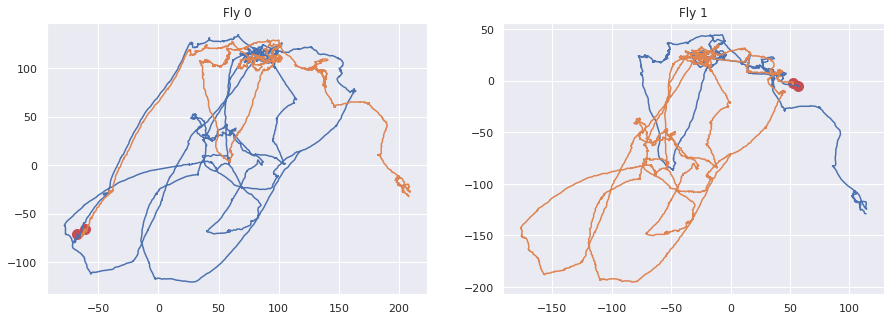

In [18]:
# %% Now let's plot them with Nicolas' result
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.plot()
plt.plot(new_flies[:, 0, 0], new_flies[:, 0, 1])
plt.plot(old_flies[:, 0, 0], old_flies[:, 0, 1])
plt.scatter(new_flies[0, 0, 0], new_flies[0, 0, 1], color='r', marker='o', s=100)
plt.scatter(old_flies[0, 0, 0], old_flies[0, 0, 1], color='r', marker='o', s=100)
plt.title('Fly 0')


plt.subplot(122)
plt.plot(new_flies[:, 1, 0], new_flies[:, 1, 1])
plt.plot(old_flies[:, 1, 0], old_flies[:, 1, 1])
plt.scatter(new_flies[0, 1, 0], new_flies[0, 1, 1], color='r', marker='o', s=100)
plt.scatter(old_flies[0, 1, 0], old_flies[0, 1, 1], color='r', marker='o', s=100)
plt.title('Fly 1')

In [35]:
# %% Let's load the data through opencv
capture = cv.VideoCapture('../../data/testing_data/4arenas/seq_1.mp4')

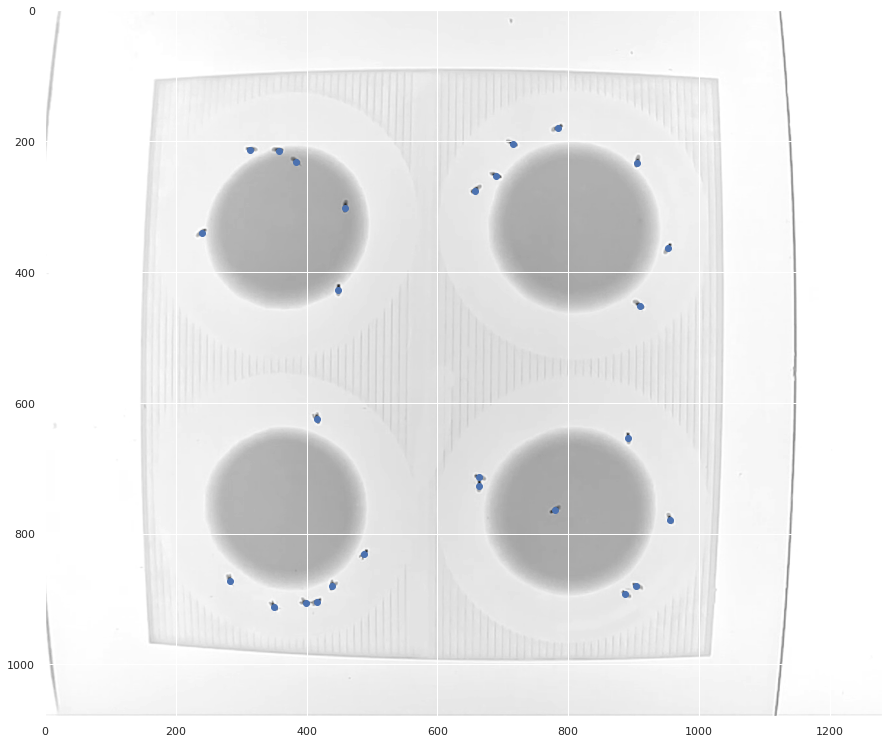

In [37]:
frame = inversion_point
capture.set(1, frame)
img = cv.cvtColor(capture.read()[1], cv.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 15))
plt.imshow(img, cmap='gray')



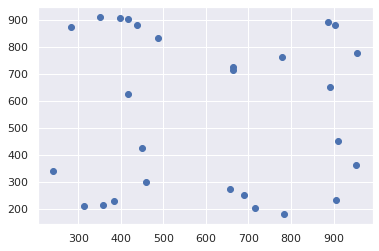

In [38]:
plt.scatter(df_new.query(f'frame == {frame}')['x'], df_new.query(f'frame == {frame}')['y'])

In [ ]:
length = 30
ini = inversion_point

    plt.plot(df_new.query(f'(ID == {ID}) and (ini-length < frame <= ini)')['x'], df_new.query(f'ID == {ID}')['y'])

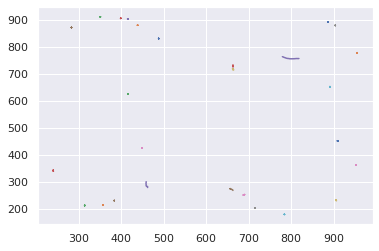

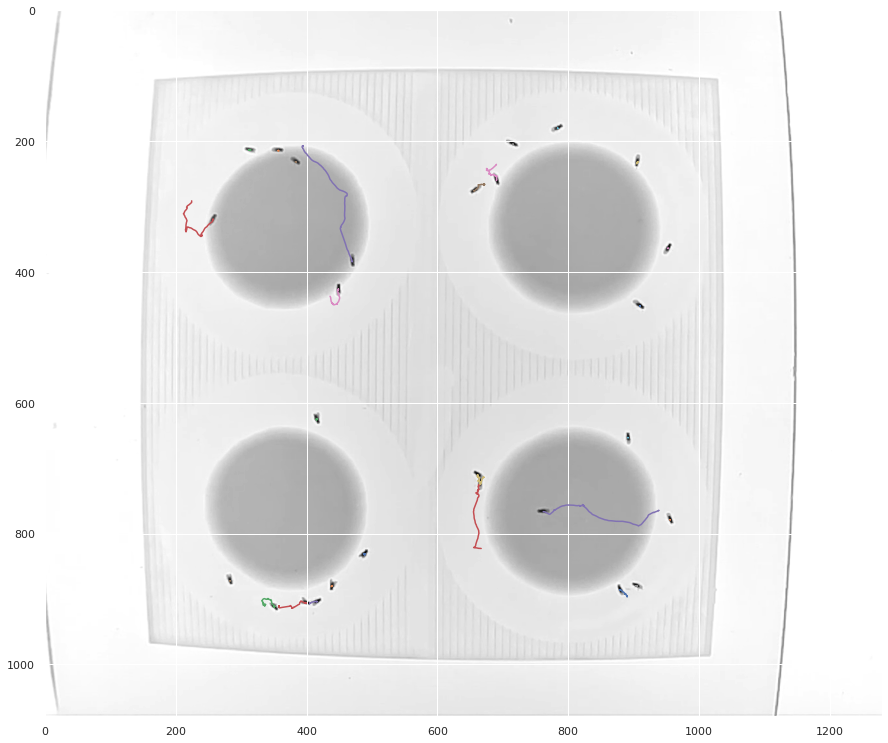

In [45]:
frame = inversion_point + 100
length = 30 * 10
capture.set(1, frame)
img = cv.cvtColor(capture.read()[1], cv.COLOR_BGR2GRAY)

plt.figure(figsize=(15, 15))
plt.imshow(img, cmap='gray')
for ID in np.arange(27):
    local_df = df_new.query(f'(ID == {ID}) and ({frame}-{length} < frame <= {frame})')
    plt.plot(local_df.x, local_df.y) 
    